In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf  # For tf.data and preprocessing only.
import keras
from keras import layers
from keras import ops

In [2]:
import pickle
import random
with open("compressed_images.pkl", "rb") as fp:
    new_data = pickle.load(fp)

random.shuffle(new_data)

In [3]:
images = np.array([item[0] for item in new_data])
labels = np.array([item[1] for item in new_data])
new_data = []

In [4]:
images= np.expand_dims(images, axis=-1)
labels = np.expand_dims(labels, axis=-1)
images.shape, labels.shape

((1500, 256, 256, 1), (1500, 1))

In [23]:
num_classes = 3
input_shape = (256, 256, 1)

patch_size = (4, 4)  # 2-by-2 sized patches
dropout_rate = 0.03  # Dropout rate
num_heads = 8  # Attention heads
embed_dim = 64  # Embedding dimension
num_mlp = 256  # MLP layer size
# Convert embedded patches to query, key, and values with a learnable additive
# value
qkv_bias = True
window_size = 4  # Size of attention window=patch size
shift_size = 1  # Size of shifting window
image_dimension = 256  # Initial image size

num_patch_x = input_shape[0] // patch_size[0]
num_patch_y = input_shape[1] // patch_size[1]

learning_rate = 1e-3
batch_size = 32
num_epochs = 10
validation_split = 0.1
weight_decay = 0.0001
label_smoothing = 0.1

In [6]:
images.shape

(1500, 256, 256, 1)

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [9]:
x_train, x_test = x_train / 255.0, x_test / 255.0

In [10]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [11]:
y_train

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [12]:
y_train.shape

(1200, 3)

In [13]:
num_train_samples = int(len(x_train) * (1 - validation_split))
num_val_samples = len(x_train) - num_train_samples
x_train, x_val = np.split(x_train, [num_train_samples])
y_train, y_val = np.split(y_train, [num_train_samples])
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


x_train shape: (1080, 256, 256, 1) - y_train shape: (1080, 3)
x_test shape: (300, 256, 256, 1) - y_test shape: (300, 3)


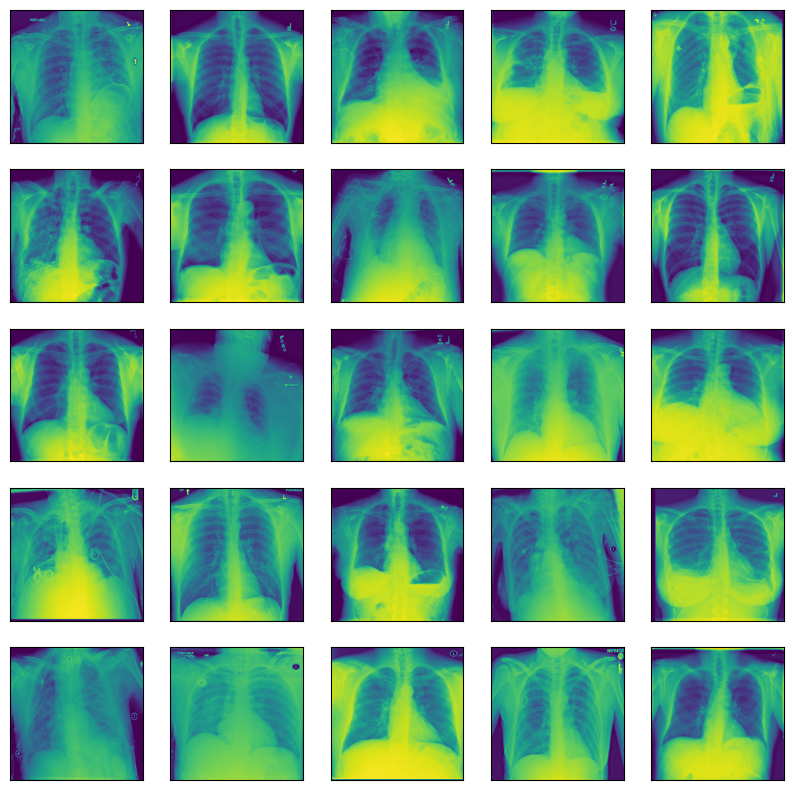

In [15]:

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
plt.show()

In [16]:
num_patch_y , patch_size[0]

(64, 4)

In [17]:

def window_partition(x, window_size):
    _, height, width, channels = x.shape
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = ops.reshape(
        x,
        (
            -1,
            patch_num_y,
            window_size,
            patch_num_x,
            window_size,
            channels,
        ),
    )
    x = ops.transpose(x, (0, 1, 3, 2, 4, 5))
    windows = ops.reshape(x, (-1, window_size, window_size, channels))
    return windows


def window_reverse(windows, window_size, height, width, channels):
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = ops.reshape(
        windows,
        (
            -1,
            patch_num_y,
            patch_num_x,
            window_size,
            window_size,
            channels,
        ),
    )
    x = ops.transpose(x, (0, 1, 3, 2, 4, 5))
    x = ops.reshape(x, (-1, height, width, channels))
    return x


In [18]:

class WindowAttention(layers.Layer):
    def __init__(
        self,
        dim,
        window_size,
        num_heads,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = layers.Dense(dim * 3, use_bias=qkv_bias)
        self.dropout = layers.Dropout(dropout_rate)
        self.proj = layers.Dense(dim)

        num_window_elements = (2 * self.window_size[0] - 1) * (
            2 * self.window_size[1] - 1
        )
        self.relative_position_bias_table = self.add_weight(
            shape=(num_window_elements, self.num_heads),
            initializer=keras.initializers.Zeros(),
            trainable=True,
        )
        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords_matrix = np.meshgrid(coords_h, coords_w, indexing="ij")
        coords = np.stack(coords_matrix)
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)

        self.relative_position_index = keras.Variable(
            initializer=relative_position_index,
            shape=relative_position_index.shape,
            dtype="int",
            trainable=False,
        )

    def call(self, x, mask=None):
        _, size, channels = x.shape
        head_dim = channels // self.num_heads
        x_qkv = self.qkv(x)
        x_qkv = ops.reshape(x_qkv, (-1, size, 3, self.num_heads, head_dim))
        x_qkv = ops.transpose(x_qkv, (2, 0, 3, 1, 4))
        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]
        q = q * self.scale
        k = ops.transpose(k, (0, 1, 3, 2))
        attn = q @ k

        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = ops.reshape(self.relative_position_index, (-1,))
        relative_position_bias = ops.take(
            self.relative_position_bias_table,
            relative_position_index_flat,
            axis=0,
        )
        relative_position_bias = ops.reshape(
            relative_position_bias,
            (num_window_elements, num_window_elements, -1),
        )
        relative_position_bias = ops.transpose(relative_position_bias, (2, 0, 1))
        attn = attn + ops.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.shape[0]
            mask_float = ops.cast(
                ops.expand_dims(ops.expand_dims(mask, axis=1), axis=0),
                "float32",
            )
            attn = ops.reshape(attn, (-1, nW, self.num_heads, size, size)) + mask_float
            attn = ops.reshape(attn, (-1, self.num_heads, size, size))
            attn = keras.activations.softmax(attn, axis=-1)
        else:
            attn = keras.activations.softmax(attn, axis=-1)
        attn = self.dropout(attn)

        x_qkv = attn @ v
        x_qkv = ops.transpose(x_qkv, (0, 2, 1, 3))
        x_qkv = ops.reshape(x_qkv, (-1, size, channels))
        x_qkv = self.proj(x_qkv)
        x_qkv = self.dropout(x_qkv)
        return x_qkv


In [19]:
class SwinTransformer(layers.Layer):
    def __init__(
        self,
        dim,
        num_patch,
        num_heads,
        window_size=7,
        shift_size=0,
        num_mlp=1024,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        super().__init__(**kwargs)

        self.dim = dim  # number of input dimensions
        self.num_patch = num_patch  # number of embedded patches
        self.num_heads = num_heads  # number of attention heads
        self.window_size = window_size  # size of window
        self.shift_size = shift_size  # size of window shift
        self.num_mlp = num_mlp  # number of MLP nodes

        self.norm1 = layers.LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(
            dim,
            window_size=(self.window_size, self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            dropout_rate=dropout_rate,
        )
        self.drop_path = layers.Dropout(dropout_rate)
        self.norm2 = layers.LayerNormalization(epsilon=1e-5)

        self.mlp = keras.Sequential(
            [
                layers.Dense(num_mlp),
                layers.Activation(keras.activations.gelu),
                layers.Dropout(dropout_rate),
                layers.Dense(dim),
                layers.Dropout(dropout_rate),
            ]
        )

        if min(self.num_patch) < self.window_size:
            self.shift_size = 0
            self.window_size = min(self.num_patch)

    def build(self, input_shape):
        if self.shift_size == 0:
            self.attn_mask = None
        else:
            height, width = self.num_patch
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            mask_array = np.zeros((1, height, width, 1))
            count = 0
            for h in h_slices:
                for w in w_slices:
                    mask_array[:, h, w, :] = count
                    count += 1
            mask_array = ops.convert_to_tensor(mask_array)

            # mask array to windows
            mask_windows = window_partition(mask_array, self.window_size)
            mask_windows = ops.reshape(
                mask_windows, [-1, self.window_size * self.window_size]
            )
            attn_mask = ops.expand_dims(mask_windows, axis=1) - ops.expand_dims(
                mask_windows, axis=2
            )
            attn_mask = ops.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = ops.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = keras.Variable(
                initializer=attn_mask,
                shape=attn_mask.shape,
                dtype=attn_mask.dtype,
                trainable=False,
            )

    def call(self, x, training=False):
        height, width = self.num_patch
        _, num_patches_before, channels = x.shape
        x_skip = x
        x = self.norm1(x)
        x = ops.reshape(x, (-1, height, width, channels))
        if self.shift_size > 0:
            shifted_x = ops.roll(
                x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2]
            )
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = ops.reshape(
            x_windows, (-1, self.window_size * self.window_size, channels)
        )
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = ops.reshape(
            attn_windows,
            (-1, self.window_size, self.window_size, channels),
        )
        shifted_x = window_reverse(
            attn_windows, self.window_size, height, width, channels
        )
        if self.shift_size > 0:
            x = ops.roll(
                shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2]
            )
        else:
            x = shifted_x

        x = ops.reshape(x, (-1, height * width, channels))
        x = self.drop_path(x, training=training)
        x = x_skip + x
        x_skip = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.drop_path(x)
        x = x_skip + x
        return x


In [20]:

# Using tf ops since it is only used in tf.data.
def patch_extract(images):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(
        images=images,
        sizes=(1, patch_size[0], patch_size[1], 1),
        strides=(1, patch_size[0], patch_size[1], 1),
        rates=(1, 1, 1, 1),
        padding="VALID",
    )
    patch_dim = patches.shape[-1]
    patch_num = patches.shape[1]
    return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = ops.arange(start=0, stop=self.num_patch)
        return self.proj(patch) + self.pos_embed(pos)


class PatchMerging(keras.layers.Layer):
    def __init__(self, num_patch, embed_dim):
        super().__init__()
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.linear_trans = layers.Dense(2 * embed_dim, use_bias=False)

    def call(self, x):
        height, width = self.num_patch
        _, _, C = x.shape
        x = ops.reshape(x, (-1, height, width, C))
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = ops.concatenate((x0, x1, x2, x3), axis=-1)
        x = ops.reshape(x, (-1, (height // 2) * (width // 2), 4 * C))
        return self.linear_trans(x)


In [21]:

def augment(x):
    x = tf.image.random_crop(x, size=(image_dimension, image_dimension, 1))
    x = tf.image.random_flip_left_right(x)
    return x


dataset = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .map(lambda x, y: (augment(x), y))
    .batch(batch_size=batch_size)
    .map(lambda x, y: (patch_extract(x), y))
    .prefetch(tf.data.experimental.AUTOTUNE)
)

dataset_val = (
    tf.data.Dataset.from_tensor_slices((x_val, y_val))
    .batch(batch_size=batch_size)
    .map(lambda x, y: (patch_extract(x), y))
    .prefetch(tf.data.experimental.AUTOTUNE)
)

dataset_test = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .batch(batch_size=batch_size)
    .map(lambda x, y: (patch_extract(x), y))
    .prefetch(tf.data.experimental.AUTOTUNE)
)

In [22]:
input = layers.Input(shape=(4096, 16))
x = PatchEmbedding(num_patch_x * num_patch_y, embed_dim)(input)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=0,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=shift_size,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = PatchMerging((num_patch_x, num_patch_y), embed_dim=embed_dim)(x)
x = layers.GlobalAveragePooling1D()(x)
output = layers.Dense(num_classes, activation="softmax")(x)

In [24]:
model = keras.Model(input, output)
model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.TopKCategoricalAccuracy(3, name="top-3-accuracy"),
    ],
)

history = model.fit(
    dataset,
    batch_size= batch_size,
    epochs= num_epochs,
    validation_data=dataset_val,
)

Epoch 1/10


17/17 ━━━━━━━━━━━━━━━━━━━━ 191s 9s/step - accuracy: 0.3673 - loss: 1.8868 - top-3-accuracy: 1.0000 - val_accuracy: 0.2583 - val_loss: 1.3793 - val_top-3-accuracy: 1.0000
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 156s 9s/step - accuracy: 0.3550 - loss: 1.2071 - top-3-accuracy: 1.0000 - val_accuracy: 0.2583 - val_loss: 1.2416 - val_top-3-accuracy: 1.0000
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 158s 9s/step - accuracy: 0.3614 - loss: 1.1192 - top-3-accuracy: 1.0000 - val_accuracy: 0.2833 - val_loss: 1.1609 - val_top-3-accuracy: 1.0000
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 164s 10s/step - accuracy: 0.4116 - loss: 1.0894 - top-3-accuracy: 1.0000 - val_accuracy: 0.2750 - val_loss: 1.1448 - val_top-3-accuracy: 1.0000
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 165s 10s/step - accuracy: 0.3866 - loss: 1.0891 - top-3-accuracy: 1.0000 - val_accuracy: 0.2917 - val_loss: 1.1488 - val_top-3-accuracy: 1.0000
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 178s 11s/step - accuracy: 0.3781 - loss: 1.0907 - top-3-accuracy: 

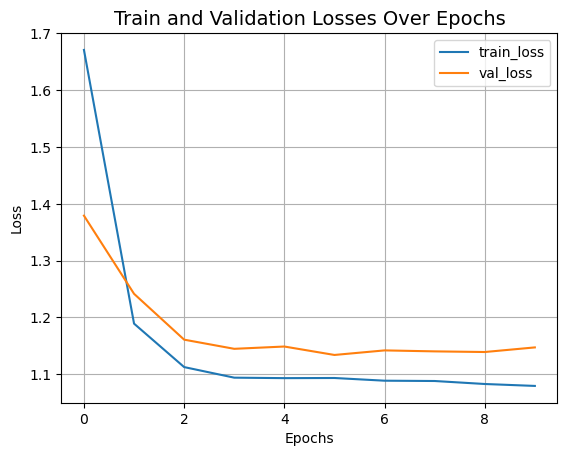

In [25]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [29]:
loss, accuracy, top_3_accuracy = model.evaluate(dataset_test)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 3 accuracy: {round(top_3_accuracy * 100, 2)}%")

5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.3380 - loss: 1.1354 - top-3-accuracy: 1.0000
Test loss: 1.13
Test accuracy: 35.33%
Test top 3 accuracy: 100.0%


In [30]:
x_test.shape,y_test.shape,x_train.shape,y_train.shape

((300, 256, 256, 1), (300, 3), (1080, 256, 256, 1), (1080, 3))

In [28]:
y_pred = model.predict(dataset_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 36s 6s/step


In [31]:
y_pred.shape, y_test.shape

((300, 3), (300, 3))

In [63]:
# y_pred = SwinTransformer.predict(x_test)
# y_pred= np.argmax (y_pred, axis = 1)

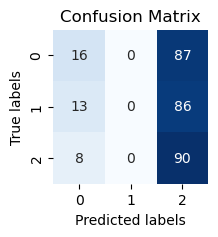

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Convert one-hot encoded vectors to class labels
# y_pred = np.argmax(y_pred, axis=1)
# y_test = np.argmax(y_test, axis=1)

# Reshape y_true to match the shape of y_pred
# y_test = np.squeeze(y_test)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(2, 2))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

In [35]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.43      0.16      0.23       103
           1       0.00      0.00      0.00        99
           2       0.34      0.92      0.50        98

    accuracy                           0.35       300
   macro avg       0.26      0.36      0.24       300
weighted avg       0.26      0.35      0.24       300



c:\Users\nimmi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nimmi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nimmi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
y_test

array([1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 2, 0, 1, 0, 1,
       0, 0, 2, 1, 0, 2, 2, 0, 1, 2, 0, 0, 1, 2, 1, 2, 2, 1, 2, 0, 0, 2,
       1, 0, 1, 2, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 2, 2, 1, 1, 0, 1, 2,
       1, 0, 2, 0, 0, 1, 1, 2, 0, 1, 1, 0, 1, 2, 2, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 2, 2, 2, 1, 1, 0, 1, 1, 1, 0, 2, 2, 1, 1, 0, 1, 2, 1, 1, 2,
       1, 1, 0, 2, 0, 0, 1, 2, 2, 0, 1, 0, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2,
       1, 2, 2, 1, 2, 0, 1, 1, 2, 0, 2, 2, 1, 1, 1, 2, 0, 1, 2, 2, 2, 2,
       2, 0, 2, 1, 0, 1, 0, 2, 2, 1, 1, 1, 0, 1, 0, 1, 0, 0, 2, 1, 2, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 0, 0, 2, 0, 0, 1, 0, 1,
       2, 2, 1, 0, 0, 0, 2, 1, 0, 0, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 0, 2,
       0, 2, 0, 0, 1, 2, 1, 1, 0, 1, 2, 1, 2, 2, 1, 0, 2, 2, 2, 1, 2, 0,
       0, 2, 1, 0, 0, 2, 0, 0, 1, 1, 0, 0, 1, 2, 0, 1, 0, 1, 1, 2, 1, 0,
       2, 2, 2, 2, 0, 0, 0, 0, 1, 1, 2, 0, 0, 1, 0, 0, 2, 2, 2, 2, 0, 0,
       0, 2, 2, 2, 0, 1, 1, 1, 2, 0, 0, 0, 0, 1], d

In [37]:
y_pred

array([2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 2,
       2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2,
       2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2,
       0, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
       0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], d